# Nighttime Lights Trends in Jordan

The purpose of this notebook is to conduct an examination of the spatial and temporal distribution of artificial lights during the night across various regions in Jordan. The dataset utilized is derived from [NASA's Black Marble](https://blackmarble.gsfc.nasa.gov).

In [1]:
import math
import os
from datetime import datetime

import colorcet as cc
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
from blackmarble.extract import bm_extract
from bokeh.models import HoverTool, Legend, Span, Title
from bokeh.plotting import figure, output_notebook, show

%load_ext autoreload
%autoreload 2

In [2]:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
bearer = os.environ.get("BLACKMARBLE_TOKEN")
VAR = "ntl_mean"

## Data

#### Define Region of Interest

Define region of interest for which NASA Black Marble will be retrieved and aggregated. We use [GADM](https://gadm.org/).

In [3]:
ROI = geopandas.read_file(
    "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_JOR_2.json.zip"
)
ROI.explore()

### Black Marble 

[NASA's Black Marble](https://blackmarble.gsfc.nasa.gov) Nighttime Lights dataset represents a remarkable advancement in our ability to monitor and understand nocturnal light emissions on a global scale. By utilizing cutting-edge satellite technology and image processing techniques, the Black Marble dataset offers a comprehensive and high-resolution view of the Earth's nighttime illumination patterns.

In [4]:
VNP46A2 = bm_extract(
    ROI,
    product_id="VNP46A2",
    date_range=pd.date_range("2023-01-01", "2024-02-15", freq="D"),
    bearer=bearer,
    aggfunc=["mean", "sum", "min", "max"],
)

VNP46A3 = bm_extract(
    ROI,
    product_id="VNP46A3",
    date_range=pd.date_range("2012-01-01", "2024-02-01", freq="MS"),
    bearer=bearer,
    aggfunc=["mean", "sum"],
)

GETTING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/790 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0.00/4.84M [00:00<?, ?B/s]

  0%|          | 0.00/4.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/4.62M [00:00<?, ?B/s]

  0%|          | 0.00/4.52M [00:00<?, ?B/s]

  0%|          | 0.00/5.51M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.69M [00:00<?, ?B/s]

  0%|          | 0.00/5.21M [00:00<?, ?B/s]

  0%|          | 0.00/5.80M [00:00<?, ?B/s]

  0%|          | 0.00/5.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/5.06M [00:00<?, ?B/s]

  0%|          | 0.00/5.50M [00:00<?, ?B/s]

  0%|          | 0.00/7.17M [00:00<?, ?B/s]

  0%|          | 0.00/5.54M [00:00<?, ?B/s]

  0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0.00/4.38M [00:00<?, ?B/s]

  0%|          | 0.00/5.11M [00:00<?, ?B/s]

  0%|          | 0.00/5.11M [00:00<?, ?B/s]

  0%|          | 0.00/6.26M [00:00<?, ?B/s]

  0%|          | 0.00/5.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.02M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/5.33M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/6.26M [00:00<?, ?B/s]

  0%|          | 0.00/4.31M [00:00<?, ?B/s]

  0%|          | 0.00/4.59M [00:00<?, ?B/s]

[2024-02-12 17:19:56 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/4.47M [00:00<?, ?B/s]

  0%|          | 0.00/5.20M [00:00<?, ?B/s]

  0%|          | 0.00/4.46M [00:00<?, ?B/s]

  0%|          | 0.00/4.21M [00:00<?, ?B/s]

  0%|          | 0.00/5.26M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/5.06M [00:00<?, ?B/s]

  0%|          | 0.00/6.08M [00:00<?, ?B/s]

  0%|          | 0.00/5.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.65M [00:00<?, ?B/s]

  0%|          | 0.00/6.21M [00:00<?, ?B/s]

  0%|          | 0.00/5.46M [00:00<?, ?B/s]

  0%|          | 0.00/4.84M [00:00<?, ?B/s]

  0%|          | 0.00/5.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/5.36M [00:00<?, ?B/s]

  0%|          | 0.00/5.43M [00:00<?, ?B/s]

  0%|          | 0.00/5.21M [00:00<?, ?B/s]

  0%|          | 0.00/6.61M [00:00<?, ?B/s]

  0%|          | 0.00/3.79M [00:00<?, ?B/s]

[2024-02-12 17:19:59 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.04M [00:00<?, ?B/s]

  0%|          | 0.00/6.42M [00:00<?, ?B/s]

  0%|          | 0.00/5.20M [00:00<?, ?B/s]

  0%|          | 0.00/5.57M [00:00<?, ?B/s]

  0%|          | 0.00/6.64M [00:00<?, ?B/s]

  0%|          | 0.00/3.88M [00:00<?, ?B/s]

  0%|          | 0.00/4.91M [00:00<?, ?B/s]

  0%|          | 0.00/5.92M [00:00<?, ?B/s]

  0%|          | 0.00/6.88M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.62M [00:00<?, ?B/s]

  0%|          | 0.00/4.47M [00:00<?, ?B/s]

  0%|          | 0.00/4.69M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/4.53M [00:00<?, ?B/s]

  0%|          | 0.00/7.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/7.30M [00:00<?, ?B/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/5.40M [00:00<?, ?B/s]

  0%|          | 0.00/7.49M [00:00<?, ?B/s]

[2024-02-12 17:20:02 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/6.04M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/5.25M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/5.19M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/5.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.33M [00:00<?, ?B/s]

  0%|          | 0.00/4.91M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.76M [00:00<?, ?B/s]

  0%|          | 0.00/6.17M [00:00<?, ?B/s]

  0%|          | 0.00/5.70M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.33M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/3.52M [00:00<?, ?B/s]

  0%|          | 0.00/3.97M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/4.91M [00:00<?, ?B/s]

  0%|          | 0.00/6.83M [00:00<?, ?B/s]

  0%|          | 0.00/3.50M [00:00<?, ?B/s]

  0%|          | 0.00/4.50M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.00M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/7.23M [00:00<?, ?B/s]

  0%|          | 0.00/6.29M [00:00<?, ?B/s]

  0%|          | 0.00/5.96M [00:00<?, ?B/s]

  0%|          | 0.00/6.51M [00:00<?, ?B/s]

  0%|          | 0.00/4.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.54M [00:00<?, ?B/s]

  0%|          | 0.00/6.26M [00:00<?, ?B/s]

  0%|          | 0.00/4.08M [00:00<?, ?B/s]

  0%|          | 0.00/5.06M [00:00<?, ?B/s]

  0%|          | 0.00/4.07M [00:00<?, ?B/s]

  0%|          | 0.00/5.60M [00:00<?, ?B/s]

  0%|          | 0.00/4.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.95M [00:00<?, ?B/s]

  0%|          | 0.00/3.64M [00:00<?, ?B/s]

  0%|          | 0.00/4.50M [00:00<?, ?B/s]

  0%|          | 0.00/3.80M [00:00<?, ?B/s]

  0%|          | 0.00/4.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/5.07M [00:00<?, ?B/s]

  0%|          | 0.00/4.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.72M [00:00<?, ?B/s]

  0%|          | 0.00/4.86M [00:00<?, ?B/s]

  0%|          | 0.00/5.54M [00:00<?, ?B/s]

  0%|          | 0.00/5.14M [00:00<?, ?B/s]

  0%|          | 0.00/4.91M [00:00<?, ?B/s]

  0%|          | 0.00/3.86M [00:00<?, ?B/s]

  0%|          | 0.00/5.61M [00:00<?, ?B/s]

  0%|          | 0.00/5.70M [00:00<?, ?B/s]

  0%|          | 0.00/5.86M [00:00<?, ?B/s]

  0%|          | 0.00/5.90M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/5.65M [00:00<?, ?B/s]

  0%|          | 0.00/3.63M [00:00<?, ?B/s]

  0%|          | 0.00/3.63M [00:00<?, ?B/s]

  0%|          | 0.00/5.50M [00:00<?, ?B/s]

  0%|          | 0.00/4.35M [00:00<?, ?B/s]

  0%|          | 0.00/5.54M [00:00<?, ?B/s]

  0%|          | 0.00/4.94M [00:00<?, ?B/s]

  0%|          | 0.00/7.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

[2024-02-12 17:20:12 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/6.00M [00:00<?, ?B/s]

  0%|          | 0.00/4.39M [00:00<?, ?B/s]

  0%|          | 0.00/4.47M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.60M [00:00<?, ?B/s]

  0%|          | 0.00/4.53M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.14M [00:00<?, ?B/s]

  0%|          | 0.00/3.97M [00:00<?, ?B/s]

  0%|          | 0.00/4.26M [00:00<?, ?B/s]

  0%|          | 0.00/3.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.94M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.07M [00:00<?, ?B/s]

  0%|          | 0.00/6.88M [00:00<?, ?B/s]

  0%|          | 0.00/6.00M [00:00<?, ?B/s]

  0%|          | 0.00/4.50M [00:00<?, ?B/s]

  0%|          | 0.00/7.21M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/5.99M [00:00<?, ?B/s]

  0%|          | 0.00/5.79M [00:00<?, ?B/s]

  0%|          | 0.00/5.92M [00:00<?, ?B/s]

  0%|          | 0.00/4.20M [00:00<?, ?B/s]

  0%|          | 0.00/4.62M [00:00<?, ?B/s]

  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/3.67M [00:00<?, ?B/s]

  0%|          | 0.00/5.42M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/4.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.94M [00:00<?, ?B/s]

  0%|          | 0.00/3.81M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.14M [00:00<?, ?B/s]

  0%|          | 0.00/4.85M [00:00<?, ?B/s]

  0%|          | 0.00/4.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/6.70M [00:00<?, ?B/s]

  0%|          | 0.00/4.32M [00:00<?, ?B/s]

  0%|          | 0.00/6.05M [00:00<?, ?B/s]

  0%|          | 0.00/6.06M [00:00<?, ?B/s]

  0%|          | 0.00/5.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.88M [00:00<?, ?B/s]

  0%|          | 0.00/4.21M [00:00<?, ?B/s]

  0%|          | 0.00/6.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/6.00M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.82M [00:00<?, ?B/s]

  0%|          | 0.00/6.07M [00:00<?, ?B/s]

  0%|          | 0.00/6.00M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/5.37M [00:00<?, ?B/s]

  0%|          | 0.00/6.80M [00:00<?, ?B/s]

  0%|          | 0.00/3.69M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/3.85M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/3.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.88M [00:00<?, ?B/s]

  0%|          | 0.00/3.88M [00:00<?, ?B/s]

  0%|          | 0.00/5.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/5.27M [00:00<?, ?B/s]

  0%|          | 0.00/7.16M [00:00<?, ?B/s]

  0%|          | 0.00/3.11M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/4.12M [00:00<?, ?B/s]

  0%|          | 0.00/5.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.35M [00:00<?, ?B/s]

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

  0%|          | 0.00/6.03M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/5.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.16M [00:00<?, ?B/s]

  0%|          | 0.00/5.46M [00:00<?, ?B/s]

  0%|          | 0.00/5.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.35M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.70M [00:00<?, ?B/s]

  0%|          | 0.00/3.59M [00:00<?, ?B/s]

  0%|          | 0.00/6.50M [00:00<?, ?B/s]

  0%|          | 0.00/4.65M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/3.79M [00:00<?, ?B/s]

  0%|          | 0.00/4.22M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.79M [00:00<?, ?B/s]

  0%|          | 0.00/5.89M [00:00<?, ?B/s]

  0%|          | 0.00/6.81M [00:00<?, ?B/s]

  0%|          | 0.00/5.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.56M [00:00<?, ?B/s]

  0%|          | 0.00/5.52M [00:00<?, ?B/s]

  0%|          | 0.00/5.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.79M [00:00<?, ?B/s]

  0%|          | 0.00/6.31M [00:00<?, ?B/s]

  0%|          | 0.00/3.79M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/3.87M [00:00<?, ?B/s]

  0%|          | 0.00/3.47M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/4.26M [00:00<?, ?B/s]

  0%|          | 0.00/7.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/6.05M [00:00<?, ?B/s]

  0%|          | 0.00/3.78M [00:00<?, ?B/s]

[2024-02-12 17:20:28 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/3.87M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.19M [00:00<?, ?B/s]

  0%|          | 0.00/6.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/3.41M [00:00<?, ?B/s]

  0%|          | 0.00/3.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.33M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/5.92M [00:00<?, ?B/s]

  0%|          | 0.00/5.11M [00:00<?, ?B/s]

  0%|          | 0.00/4.75M [00:00<?, ?B/s]

  0%|          | 0.00/5.84M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/3.43M [00:00<?, ?B/s]

  0%|          | 0.00/6.02M [00:00<?, ?B/s]

  0%|          | 0.00/6.60M [00:00<?, ?B/s]

  0%|          | 0.00/3.97M [00:00<?, ?B/s]

  0%|          | 0.00/4.20M [00:00<?, ?B/s]

  0%|          | 0.00/5.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.45M [00:00<?, ?B/s]

  0%|          | 0.00/5.60M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/6.61M [00:00<?, ?B/s]

  0%|          | 0.00/4.85M [00:00<?, ?B/s]

  0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0.00/5.65M [00:00<?, ?B/s]

  0%|          | 0.00/5.24M [00:00<?, ?B/s]

  0%|          | 0.00/5.61M [00:00<?, ?B/s]

  0%|          | 0.00/6.85M [00:00<?, ?B/s]

  0%|          | 0.00/5.44M [00:00<?, ?B/s]

  0%|          | 0.00/6.00M [00:00<?, ?B/s]

  0%|          | 0.00/6.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/6.47M [00:00<?, ?B/s]

  0%|          | 0.00/5.02M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/4.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/3.71M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/6.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.88M [00:00<?, ?B/s]

  0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0.00/4.98M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/5.25M [00:00<?, ?B/s]

  0%|          | 0.00/5.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/5.31M [00:00<?, ?B/s]

  0%|          | 0.00/6.73M [00:00<?, ?B/s]

  0%|          | 0.00/5.19M [00:00<?, ?B/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.91M [00:00<?, ?B/s]

  0%|          | 0.00/4.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.72M [00:00<?, ?B/s]

  0%|          | 0.00/6.61M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/6.77M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/6.09M [00:00<?, ?B/s]

  0%|          | 0.00/6.76M [00:00<?, ?B/s]

  0%|          | 0.00/5.11M [00:00<?, ?B/s]

  0%|          | 0.00/5.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.46M [00:00<?, ?B/s]

  0%|          | 0.00/6.00M [00:00<?, ?B/s]

  0%|          | 0.00/4.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.53M [00:00<?, ?B/s]

  0%|          | 0.00/5.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.93M [00:00<?, ?B/s]

  0%|          | 0.00/5.24M [00:00<?, ?B/s]

  0%|          | 0.00/5.04M [00:00<?, ?B/s]

  0%|          | 0.00/4.52M [00:00<?, ?B/s]

  0%|          | 0.00/5.18M [00:00<?, ?B/s]

  0%|          | 0.00/4.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.97M [00:00<?, ?B/s]

  0%|          | 0.00/6.03M [00:00<?, ?B/s]

  0%|          | 0.00/6.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.47M [00:00<?, ?B/s]

  0%|          | 0.00/5.31M [00:00<?, ?B/s]

  0%|          | 0.00/5.72M [00:00<?, ?B/s]

  0%|          | 0.00/5.38M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/6.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.13M [00:00<?, ?B/s]

  0%|          | 0.00/6.27M [00:00<?, ?B/s]

  0%|          | 0.00/5.89M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/4.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.29M [00:00<?, ?B/s]

  0%|          | 0.00/4.79M [00:00<?, ?B/s]

  0%|          | 0.00/5.23M [00:00<?, ?B/s]

  0%|          | 0.00/4.57M [00:00<?, ?B/s]

  0%|          | 0.00/3.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.35M [00:00<?, ?B/s]

  0%|          | 0.00/4.75M [00:00<?, ?B/s]

  0%|          | 0.00/3.97M [00:00<?, ?B/s]

  0%|          | 0.00/3.82M [00:00<?, ?B/s]

  0%|          | 0.00/3.76M [00:00<?, ?B/s]

  0%|          | 0.00/4.24M [00:00<?, ?B/s]

  0%|          | 0.00/4.70M [00:00<?, ?B/s]

  0%|          | 0.00/4.83M [00:00<?, ?B/s]

  0%|          | 0.00/5.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.03M [00:00<?, ?B/s]

  0%|          | 0.00/7.24M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.41M [00:00<?, ?B/s]

  0%|          | 0.00/4.69M [00:00<?, ?B/s]

  0%|          | 0.00/3.60M [00:00<?, ?B/s]

  0%|          | 0.00/3.74M [00:00<?, ?B/s]

  0%|          | 0.00/5.40M [00:00<?, ?B/s]

  0%|          | 0.00/3.61M [00:00<?, ?B/s]

  0%|          | 0.00/3.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/5.11M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/5.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.23M [00:00<?, ?B/s]

  0%|          | 0.00/3.90M [00:00<?, ?B/s]

  0%|          | 0.00/5.00M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.25M [00:00<?, ?B/s]

  0%|          | 0.00/5.13M [00:00<?, ?B/s]

  0%|          | 0.00/4.05M [00:00<?, ?B/s]

  0%|          | 0.00/6.37M [00:00<?, ?B/s]

  0%|          | 0.00/5.76M [00:00<?, ?B/s]

  0%|          | 0.00/4.94M [00:00<?, ?B/s]

  0%|          | 0.00/6.04M [00:00<?, ?B/s]

  0%|          | 0.00/6.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/4.65M [00:00<?, ?B/s]

  0%|          | 0.00/4.95M [00:00<?, ?B/s]

  0%|          | 0.00/5.31M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/4.70M [00:00<?, ?B/s]

  0%|          | 0.00/4.19M [00:00<?, ?B/s]

  0%|          | 0.00/5.65M [00:00<?, ?B/s]

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/4.82M [00:00<?, ?B/s]

  0%|          | 0.00/5.85M [00:00<?, ?B/s]

  0%|          | 0.00/5.27M [00:00<?, ?B/s]

  0%|          | 0.00/6.08M [00:00<?, ?B/s]

  0%|          | 0.00/4.38M [00:00<?, ?B/s]

  0%|          | 0.00/4.46M [00:00<?, ?B/s]

  0%|          | 0.00/3.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.28M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/4.98M [00:00<?, ?B/s]

  0%|          | 0.00/5.08M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

[2024-02-12 17:20:50 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/4.71M [00:00<?, ?B/s]

  0%|          | 0.00/4.62M [00:00<?, ?B/s]

  0%|          | 0.00/5.18M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/5.91M [00:00<?, ?B/s]

  0%|          | 0.00/4.83M [00:00<?, ?B/s]

  0%|          | 0.00/6.01M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/5.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/5.31M [00:00<?, ?B/s]

  0%|          | 0.00/5.46M [00:00<?, ?B/s]

  0%|          | 0.00/5.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.85M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/5.76M [00:00<?, ?B/s]

  0%|          | 0.00/4.71M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/5.01M [00:00<?, ?B/s]

  0%|          | 0.00/5.24M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.53M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/6.14M [00:00<?, ?B/s]

  0%|          | 0.00/5.17M [00:00<?, ?B/s]

  0%|          | 0.00/4.88M [00:00<?, ?B/s]

  0%|          | 0.00/5.62M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/5.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.86M [00:00<?, ?B/s]

  0%|          | 0.00/5.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.77M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.98M [00:00<?, ?B/s]

  0%|          | 0.00/6.14M [00:00<?, ?B/s]

  0%|          | 0.00/5.95M [00:00<?, ?B/s]

  0%|          | 0.00/5.21M [00:00<?, ?B/s]

  0%|          | 0.00/4.60M [00:00<?, ?B/s]

  0%|          | 0.00/5.38M [00:00<?, ?B/s]

[2024-02-12 17:20:56 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/5.43M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.90M [00:00<?, ?B/s]

  0%|          | 0.00/5.49M [00:00<?, ?B/s]

  0%|          | 0.00/5.12M [00:00<?, ?B/s]

  0%|          | 0.00/5.76M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/6.17M [00:00<?, ?B/s]

  0%|          | 0.00/5.20M [00:00<?, ?B/s]

  0%|          | 0.00/5.37M [00:00<?, ?B/s]

  0%|          | 0.00/4.69M [00:00<?, ?B/s]

  0%|          | 0.00/5.91M [00:00<?, ?B/s]

  0%|          | 0.00/5.92M [00:00<?, ?B/s]

  0%|          | 0.00/4.55M [00:00<?, ?B/s]

  0%|          | 0.00/6.97M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/5.24M [00:00<?, ?B/s]

  0%|          | 0.00/4.47M [00:00<?, ?B/s]

  0%|          | 0.00/7.46M [00:00<?, ?B/s]

  0%|          | 0.00/6.02M [00:00<?, ?B/s]

  0%|          | 0.00/5.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.85M [00:00<?, ?B/s]

  0%|          | 0.00/4.52M [00:00<?, ?B/s]

  0%|          | 0.00/5.34M [00:00<?, ?B/s]

  0%|          | 0.00/4.74M [00:00<?, ?B/s]

  0%|          | 0.00/5.18M [00:00<?, ?B/s]

  0%|          | 0.00/6.57M [00:00<?, ?B/s]

  0%|          | 0.00/5.52M [00:00<?, ?B/s]

  0%|          | 0.00/5.59M [00:00<?, ?B/s]

  0%|          | 0.00/4.83M [00:00<?, ?B/s]

  0%|          | 0.00/5.35M [00:00<?, ?B/s]

  0%|          | 0.00/4.59M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

  0%|          | 0.00/4.54M [00:00<?, ?B/s]

  0%|          | 0.00/5.70M [00:00<?, ?B/s]

  0%|          | 0.00/5.45M [00:00<?, ?B/s]

  0%|          | 0.00/6.70M [00:00<?, ?B/s]

  0%|          | 0.00/4.76M [00:00<?, ?B/s]

  0%|          | 0.00/5.13M [00:00<?, ?B/s]

  0%|          | 0.00/4.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/4.46M [00:00<?, ?B/s]

  0%|          | 0.00/5.03M [00:00<?, ?B/s]

  0%|          | 0.00/5.51M [00:00<?, ?B/s]

  0%|          | 0.00/5.00M [00:00<?, ?B/s]

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

  0%|          | 0.00/5.54M [00:00<?, ?B/s]

  0%|          | 0.00/6.97M [00:00<?, ?B/s]

  0%|          | 0.00/5.45M [00:00<?, ?B/s]

  0%|          | 0.00/6.21M [00:00<?, ?B/s]

  0%|          | 0.00/6.85M [00:00<?, ?B/s]

  0%|          | 0.00/7.14M [00:00<?, ?B/s]

  0%|          | 0.00/3.92M [00:00<?, ?B/s]

  0%|          | 0.00/4.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/5.24M [00:00<?, ?B/s]

  0%|          | 0.00/6.51M [00:00<?, ?B/s]

  0%|          | 0.00/3.63M [00:00<?, ?B/s]

  0%|          | 0.00/6.18M [00:00<?, ?B/s]

  0%|          | 0.00/6.53M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/5.81M [00:00<?, ?B/s]

  0%|          | 0.00/3.89M [00:00<?, ?B/s]

  0%|          | 0.00/3.46M [00:00<?, ?B/s]

  0%|          | 0.00/5.13M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.14M [00:00<?, ?B/s]

  0%|          | 0.00/5.39M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/4.54M [00:00<?, ?B/s]

  0%|          | 0.00/4.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.33M [00:00<?, ?B/s]

  0%|          | 0.00/3.48M [00:00<?, ?B/s]

  0%|          | 0.00/4.24M [00:00<?, ?B/s]

  0%|          | 0.00/5.60M [00:00<?, ?B/s]

  0%|          | 0.00/3.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.41M [00:00<?, ?B/s]

  0%|          | 0.00/5.94M [00:00<?, ?B/s]

  0%|          | 0.00/3.84M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.90M [00:00<?, ?B/s]

  0%|          | 0.00/7.18M [00:00<?, ?B/s]

  0%|          | 0.00/3.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/5.41M [00:00<?, ?B/s]

  0%|          | 0.00/6.45M [00:00<?, ?B/s]

  0%|          | 0.00/4.32M [00:00<?, ?B/s]

  0%|          | 0.00/6.20M [00:00<?, ?B/s]

  0%|          | 0.00/4.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.85M [00:00<?, ?B/s]

  0%|          | 0.00/4.41M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/3.93M [00:00<?, ?B/s]

  0%|          | 0.00/3.79M [00:00<?, ?B/s]

  0%|          | 0.00/5.53M [00:00<?, ?B/s]

  0%|          | 0.00/5.70M [00:00<?, ?B/s]

  0%|          | 0.00/3.08M [00:00<?, ?B/s]

  0%|          | 0.00/4.32M [00:00<?, ?B/s]

  0%|          | 0.00/4.06M [00:00<?, ?B/s]

  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/4.19M [00:00<?, ?B/s]

  0%|          | 0.00/6.32M [00:00<?, ?B/s]

  0%|          | 0.00/3.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.65M [00:00<?, ?B/s]

  0%|          | 0.00/3.76M [00:00<?, ?B/s]

  0%|          | 0.00/4.72M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.57M [00:00<?, ?B/s]

  0%|          | 0.00/3.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/4.55M [00:00<?, ?B/s]

  0%|          | 0.00/5.29M [00:00<?, ?B/s]

  0%|          | 0.00/4.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.03M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/5.08M [00:00<?, ?B/s]

  0%|          | 0.00/5.97M [00:00<?, ?B/s]

  0%|          | 0.00/4.35M [00:00<?, ?B/s]

  0%|          | 0.00/4.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.59M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.97M [00:00<?, ?B/s]

  0%|          | 0.00/3.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.72M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/3.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.57M [00:00<?, ?B/s]

  0%|          | 0.00/3.73M [00:00<?, ?B/s]

  0%|          | 0.00/3.72M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.21M [00:00<?, ?B/s]

  0%|          | 0.00/5.19M [00:00<?, ?B/s]

  0%|          | 0.00/4.53M [00:00<?, ?B/s]

  0%|          | 0.00/6.17M [00:00<?, ?B/s]

  0%|          | 0.00/3.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/5.38M [00:00<?, ?B/s]

  0%|          | 0.00/3.31M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0.00/4.82M [00:00<?, ?B/s]

  0%|          | 0.00/4.46M [00:00<?, ?B/s]

  0%|          | 0.00/6.17M [00:00<?, ?B/s]

  0%|          | 0.00/3.92M [00:00<?, ?B/s]

  0%|          | 0.00/4.38M [00:00<?, ?B/s]

  0%|          | 0.00/4.75M [00:00<?, ?B/s]

  0%|          | 0.00/4.38M [00:00<?, ?B/s]

  0%|          | 0.00/4.18M [00:00<?, ?B/s]

  0%|          | 0.00/3.75M [00:00<?, ?B/s]

  0%|          | 0.00/4.54M [00:00<?, ?B/s]

  0%|          | 0.00/3.59M [00:00<?, ?B/s]

  0%|          | 0.00/4.62M [00:00<?, ?B/s]

  0%|          | 0.00/5.02M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/4.02M [00:00<?, ?B/s]

  0%|          | 0.00/5.16M [00:00<?, ?B/s]

  0%|          | 0.00/4.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.53M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/4.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.06M [00:00<?, ?B/s]

  0%|          | 0.00/4.92M [00:00<?, ?B/s]

  0%|          | 0.00/5.16M [00:00<?, ?B/s]

  0%|          | 0.00/4.29M [00:00<?, ?B/s]

  0%|          | 0.00/4.32M [00:00<?, ?B/s]

  0%|          | 0.00/3.82M [00:00<?, ?B/s]

  0%|          | 0.00/3.81M [00:00<?, ?B/s]

  0%|          | 0.00/6.13M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/4.98M [00:00<?, ?B/s]

  0%|          | 0.00/4.61M [00:00<?, ?B/s]

  0%|          | 0.00/3.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.65M [00:00<?, ?B/s]

  0%|          | 0.00/3.79M [00:00<?, ?B/s]

  0%|          | 0.00/3.93M [00:00<?, ?B/s]

  0%|          | 0.00/5.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.50M [00:00<?, ?B/s]

  0%|          | 0.00/5.53M [00:00<?, ?B/s]

  0%|          | 0.00/4.74M [00:00<?, ?B/s]

  0%|          | 0.00/3.94M [00:00<?, ?B/s]

  0%|          | 0.00/4.46M [00:00<?, ?B/s]

  0%|          | 0.00/3.76M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/3.87M [00:00<?, ?B/s]

  0%|          | 0.00/3.54M [00:00<?, ?B/s]

  0%|          | 0.00/3.50M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/3.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.21M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/3.35M [00:00<?, ?B/s]

  0%|          | 0.00/4.53M [00:00<?, ?B/s]

  0%|          | 0.00/4.29M [00:00<?, ?B/s]

  0%|          | 0.00/3.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.95M [00:00<?, ?B/s]

  0%|          | 0.00/3.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.18M [00:00<?, ?B/s]

  0%|          | 0.00/2.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.13M [00:00<?, ?B/s]

  0%|          | 0.00/3.75M [00:00<?, ?B/s]

  0%|          | 0.00/3.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.29M [00:00<?, ?B/s]

  0%|          | 0.00/4.31M [00:00<?, ?B/s]

  0%|          | 0.00/3.66M [00:00<?, ?B/s]

  0%|          | 0.00/6.16M [00:00<?, ?B/s]

  0%|          | 0.00/3.57M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

  0%|          | 0.00/3.72M [00:00<?, ?B/s]

  0%|          | 0.00/3.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/4.82M [00:00<?, ?B/s]

  0%|          | 0.00/3.62M [00:00<?, ?B/s]

  0%|          | 0.00/2.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.56M [00:00<?, ?B/s]

  0%|          | 0.00/3.95M [00:00<?, ?B/s]

  0%|          | 0.00/3.65M [00:00<?, ?B/s]

  0%|          | 0.00/4.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.42M [00:00<?, ?B/s]

  0%|          | 0.00/2.68M [00:00<?, ?B/s]

  0%|          | 0.00/3.46M [00:00<?, ?B/s]

  0%|          | 0.00/4.87M [00:00<?, ?B/s]

  0%|          | 0.00/4.47M [00:00<?, ?B/s]

  0%|          | 0.00/2.70M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.06M [00:00<?, ?B/s]

  0%|          | 0.00/4.16M [00:00<?, ?B/s]

  0%|          | 0.00/4.32M [00:00<?, ?B/s]

  0%|          | 0.00/3.56M [00:00<?, ?B/s]

  0%|          | 0.00/4.41M [00:00<?, ?B/s]

  0%|          | 0.00/4.46M [00:00<?, ?B/s]

  0%|          | 0.00/3.88M [00:00<?, ?B/s]

  0%|          | 0.00/4.05M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/3.62M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.70M [00:00<?, ?B/s]

  0%|          | 0.00/5.13M [00:00<?, ?B/s]

  0%|          | 0.00/3.66M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.64M [00:00<?, ?B/s]

  0%|          | 0.00/3.88M [00:00<?, ?B/s]

  0%|          | 0.00/3.73M [00:00<?, ?B/s]

  0%|          | 0.00/3.69M [00:00<?, ?B/s]

  0%|          | 0.00/5.45M [00:00<?, ?B/s]

  0%|          | 0.00/2.07M [00:00<?, ?B/s]

  0%|          | 0.00/4.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/3.93M [00:00<?, ?B/s]

  0%|          | 0.00/3.77M [00:00<?, ?B/s]

  0%|          | 0.00/5.29M [00:00<?, ?B/s]

  0%|          | 0.00/4.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.48M [00:00<?, ?B/s]

  0%|          | 0.00/5.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/2.37M [00:00<?, ?B/s]

  0%|          | 0.00/4.59M [00:00<?, ?B/s]

  0%|          | 0.00/4.69M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/3.83M [00:00<?, ?B/s]

  0%|          | 0.00/3.75M [00:00<?, ?B/s]

  0%|          | 0.00/4.04M [00:00<?, ?B/s]

  0%|          | 0.00/4.22M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.76M [00:00<?, ?B/s]

  0%|          | 0.00/4.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.52M [00:00<?, ?B/s]

  0%|          | 0.00/4.33M [00:00<?, ?B/s]

  0%|          | 0.00/3.55M [00:00<?, ?B/s]

  0%|          | 0.00/4.85M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.03M [00:00<?, ?B/s]

  0%|          | 0.00/5.97M [00:00<?, ?B/s]

  0%|          | 0.00/5.01M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/3.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/5.88M [00:00<?, ?B/s]

  0%|          | 0.00/4.51M [00:00<?, ?B/s]

  0%|          | 0.00/5.37M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/790 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/411 [00:00<?, ?it/s]

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/290 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0.00/18.7M [00:00<?, ?B/s]

  0%|          | 0.00/16.8M [00:00<?, ?B/s]

  0%|          | 0.00/16.8M [00:00<?, ?B/s]

  0%|          | 0.00/17.4M [00:00<?, ?B/s]

  0%|          | 0.00/16.9M [00:00<?, ?B/s]

  0%|          | 0.00/20.5M [00:00<?, ?B/s]

  0%|          | 0.00/19.2M [00:00<?, ?B/s]

  0%|          | 0.00/16.2M [00:00<?, ?B/s]

  0%|          | 0.00/16.3M [00:00<?, ?B/s]

  0%|          | 0.00/19.9M [00:00<?, ?B/s]

  0%|          | 0.00/19.8M [00:00<?, ?B/s]

[2024-02-12 17:26:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/15.4M [00:00<?, ?B/s]

  0%|          | 0.00/19.0M [00:00<?, ?B/s]

  0%|          | 0.00/21.8M [00:00<?, ?B/s]

  0%|          | 0.00/19.4M [00:00<?, ?B/s]

  0%|          | 0.00/17.2M [00:00<?, ?B/s]

  0%|          | 0.00/16.3M [00:00<?, ?B/s]

[2024-02-12 17:26:01 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/15.7M [00:00<?, ?B/s]

  0%|          | 0.00/16.9M [00:00<?, ?B/s]

  0%|          | 0.00/15.5M [00:00<?, ?B/s]

  0%|          | 0.00/15.8M [00:00<?, ?B/s]

  0%|          | 0.00/15.5M [00:00<?, ?B/s]

[2024-02-12 17:26:03 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.5M [00:00<?, ?B/s]

  0%|          | 0.00/17.7M [00:00<?, ?B/s]

  0%|          | 0.00/16.9M [00:00<?, ?B/s]

[2024-02-12 17:26:04 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/15.6M [00:00<?, ?B/s]

[2024-02-12 17:26:05 - backoff:105 - INFO] Backing off _download_file(...) for 1.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.0M [00:00<?, ?B/s]

[2024-02-12 17:26:05 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.5M [00:00<?, ?B/s]

  0%|          | 0.00/20.1M [00:00<?, ?B/s]

[2024-02-12 17:26:06 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.0M [00:00<?, ?B/s]

[2024-02-12 17:26:07 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.1M [00:00<?, ?B/s]

  0%|          | 0.00/17.3M [00:00<?, ?B/s]

  0%|          | 0.00/18.8M [00:00<?, ?B/s]

  0%|          | 0.00/18.3M [00:00<?, ?B/s]

  0%|          | 0.00/15.3M [00:00<?, ?B/s]

[2024-02-12 17:26:08 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

  0%|          | 0.00/16.6M [00:00<?, ?B/s]

[2024-02-12 17:26:10 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:10 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:10 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:10 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:11 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.3M [00:00<?, ?B/s]

  0%|          | 0.00/21.8M [00:00<?, ?B/s]

[2024-02-12 17:26:12 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:12 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:12 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:12 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.5M [00:00<?, ?B/s]

[2024-02-12 17:26:13 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/20.8M [00:00<?, ?B/s]

  0%|          | 0.00/17.0M [00:00<?, ?B/s]

  0%|          | 0.00/18.1M [00:00<?, ?B/s]

  0%|          | 0.00/15.7M [00:00<?, ?B/s]

  0%|          | 0.00/16.2M [00:00<?, ?B/s]

[2024-02-12 17:26:14 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/15.8M [00:00<?, ?B/s]

  0%|          | 0.00/16.0M [00:00<?, ?B/s]

[2024-02-12 17:26:15 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/15.9M [00:00<?, ?B/s]

  0%|          | 0.00/17.5M [00:00<?, ?B/s]

  0%|          | 0.00/17.2M [00:00<?, ?B/s]

  0%|          | 0.00/17.0M [00:00<?, ?B/s]

  0%|          | 0.00/17.4M [00:00<?, ?B/s]

[2024-02-12 17:26:17 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/22.8M [00:00<?, ?B/s]

[2024-02-12 17:26:17 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/22.4M [00:00<?, ?B/s]

  0%|          | 0.00/21.6M [00:00<?, ?B/s]

  0%|          | 0.00/16.2M [00:00<?, ?B/s]

  0%|          | 0.00/17.7M [00:00<?, ?B/s]

  0%|          | 0.00/18.2M [00:00<?, ?B/s]

[2024-02-12 17:26:19 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.5M [00:00<?, ?B/s]

[2024-02-12 17:26:19 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.3M [00:00<?, ?B/s]

  0%|          | 0.00/16.1M [00:00<?, ?B/s]

[2024-02-12 17:26:20 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.8M [00:00<?, ?B/s]

  0%|          | 0.00/19.1M [00:00<?, ?B/s]

[2024-02-12 17:26:21 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.8M [00:00<?, ?B/s]

[2024-02-12 17:26:22 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:22 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.9M [00:00<?, ?B/s]

  0%|          | 0.00/20.9M [00:00<?, ?B/s]

[2024-02-12 17:26:23 - backoff:105 - INFO] Backing off _download_file(...) for 1.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.5M [00:00<?, ?B/s]

  0%|          | 0.00/18.2M [00:00<?, ?B/s]

[2024-02-12 17:26:23 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.3M [00:00<?, ?B/s]

[2024-02-12 17:26:25 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/21.5M [00:00<?, ?B/s]

  0%|          | 0.00/17.9M [00:00<?, ?B/s]

  0%|          | 0.00/18.5M [00:00<?, ?B/s]

[2024-02-12 17:26:25 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.6M [00:00<?, ?B/s]

  0%|          | 0.00/16.0M [00:00<?, ?B/s]

  0%|          | 0.00/17.3M [00:00<?, ?B/s]

  0%|          | 0.00/16.0M [00:00<?, ?B/s]

  0%|          | 0.00/15.9M [00:00<?, ?B/s]

  0%|          | 0.00/17.9M [00:00<?, ?B/s]

[2024-02-12 17:26:27 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:27 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/22.3M [00:00<?, ?B/s]

[2024-02-12 17:26:29 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:29 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.3M [00:00<?, ?B/s]

[2024-02-12 17:26:30 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:30 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:31 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:31 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.2M [00:00<?, ?B/s]

  0%|          | 0.00/20.3M [00:00<?, ?B/s]

  0%|          | 0.00/18.2M [00:00<?, ?B/s]

  0%|          | 0.00/16.9M [00:00<?, ?B/s]

  0%|          | 0.00/19.5M [00:00<?, ?B/s]

  0%|          | 0.00/17.7M [00:00<?, ?B/s]

  0%|          | 0.00/18.0M [00:00<?, ?B/s]

  0%|          | 0.00/16.3M [00:00<?, ?B/s]

  0%|          | 0.00/18.7M [00:00<?, ?B/s]

[2024-02-12 17:26:33 - backoff:105 - INFO] Backing off _download_file(...) for 3.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:34 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.2M [00:00<?, ?B/s]

  0%|          | 0.00/18.4M [00:00<?, ?B/s]

  0%|          | 0.00/19.1M [00:00<?, ?B/s]

[2024-02-12 17:26:35 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/21.5M [00:00<?, ?B/s]

  0%|          | 0.00/20.8M [00:00<?, ?B/s]

  0%|          | 0.00/19.5M [00:00<?, ?B/s]

  0%|          | 0.00/19.3M [00:00<?, ?B/s]

  0%|          | 0.00/18.8M [00:00<?, ?B/s]

  0%|          | 0.00/17.1M [00:00<?, ?B/s]

  0%|          | 0.00/17.0M [00:00<?, ?B/s]

  0%|          | 0.00/15.7M [00:00<?, ?B/s]

  0%|          | 0.00/18.4M [00:00<?, ?B/s]

  0%|          | 0.00/16.8M [00:00<?, ?B/s]

  0%|          | 0.00/18.9M [00:00<?, ?B/s]

  0%|          | 0.00/16.6M [00:00<?, ?B/s]

  0%|          | 0.00/16.2M [00:00<?, ?B/s]

  0%|          | 0.00/21.1M [00:00<?, ?B/s]

  0%|          | 0.00/18.0M [00:00<?, ?B/s]

  0%|          | 0.00/16.7M [00:00<?, ?B/s]

  0%|          | 0.00/14.9M [00:00<?, ?B/s]

[2024-02-12 17:26:41 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.0M [00:00<?, ?B/s]

  0%|          | 0.00/17.8M [00:00<?, ?B/s]

  0%|          | 0.00/16.4M [00:00<?, ?B/s]

  0%|          | 0.00/16.6M [00:00<?, ?B/s]

  0%|          | 0.00/18.4M [00:00<?, ?B/s]

[2024-02-12 17:26:43 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.5M [00:00<?, ?B/s]

[2024-02-12 17:26:44 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/19.1M [00:00<?, ?B/s]

[2024-02-12 17:26:45 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.3M [00:00<?, ?B/s]

[2024-02-12 17:26:45 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/22.3M [00:00<?, ?B/s]

[2024-02-12 17:26:46 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.5M [00:00<?, ?B/s]

[2024-02-12 17:26:46 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/16.7M [00:00<?, ?B/s]

[2024-02-12 17:26:47 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:47 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:48 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:48 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:48 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/20.2M [00:00<?, ?B/s]

  0%|          | 0.00/17.7M [00:00<?, ?B/s]

[2024-02-12 17:26:49 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:49 - backoff:105 - INFO] Backing off _download_file(...) for 2.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:49 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.1M [00:00<?, ?B/s]

  0%|          | 0.00/19.1M [00:00<?, ?B/s]

[2024-02-12 17:26:51 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/20.2M [00:00<?, ?B/s]

  0%|          | 0.00/20.3M [00:00<?, ?B/s]

[2024-02-12 17:26:52 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:52 - backoff:105 - INFO] Backing off _download_file(...) for 1.2s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:52 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:52 - backoff:105 - INFO] Backing off _download_file(...) for 1.2s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:53 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.3M [00:00<?, ?B/s]

  0%|          | 0.00/18.2M [00:00<?, ?B/s]

[2024-02-12 17:26:54 - backoff:105 - INFO] Backing off _download_file(...) for 3.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:54 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:54 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/22.7M [00:00<?, ?B/s]

[2024-02-12 17:26:55 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/18.8M [00:00<?, ?B/s]

  0%|          | 0.00/18.0M [00:00<?, ?B/s]

  0%|          | 0.00/22.1M [00:00<?, ?B/s]

[2024-02-12 17:26:56 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/19.9M [00:00<?, ?B/s]

  0%|          | 0.00/18.8M [00:00<?, ?B/s]

[2024-02-12 17:26:57 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:57 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/7.36M [00:00<?, ?B/s]

[2024-02-12 17:26:58 - backoff:105 - INFO] Backing off _download_file(...) for 1.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:58 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:58 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/8.70M [00:00<?, ?B/s]

[2024-02-12 17:26:59 - backoff:105 - INFO] Backing off _download_file(...) for 3.1s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:26:59 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.3M [00:00<?, ?B/s]

  0%|          | 0.00/9.52M [00:00<?, ?B/s]

[2024-02-12 17:27:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/25.1M [00:00<?, ?B/s]

  0%|          | 0.00/23.6M [00:00<?, ?B/s]

[2024-02-12 17:27:00 - backoff:105 - INFO] Backing off _download_file(...) for 2.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.81M [00:00<?, ?B/s]

  0%|          | 0.00/17.1M [00:00<?, ?B/s]

  0%|          | 0.00/13.8M [00:00<?, ?B/s]

  0%|          | 0.00/21.5M [00:00<?, ?B/s]

  0%|          | 0.00/11.0M [00:00<?, ?B/s]

  0%|          | 0.00/19.0M [00:00<?, ?B/s]

  0%|          | 0.00/21.2M [00:00<?, ?B/s]

  0%|          | 0.00/20.4M [00:00<?, ?B/s]

  0%|          | 0.00/9.47M [00:00<?, ?B/s]

[2024-02-12 17:27:03 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:04 - backoff:105 - INFO] Backing off _download_file(...) for 1.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/21.3M [00:00<?, ?B/s]

[2024-02-12 17:27:04 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.5M [00:00<?, ?B/s]

  0%|          | 0.00/11.1M [00:00<?, ?B/s]

[2024-02-12 17:27:06 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.5M [00:00<?, ?B/s]

[2024-02-12 17:27:07 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:07 - backoff:105 - INFO] Backing off _download_file(...) for 2.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:07 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/19.1M [00:00<?, ?B/s]

[2024-02-12 17:27:08 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:08 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:09 - backoff:105 - INFO] Backing off _download_file(...) for 0.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:09 - backoff:105 - INFO] Backing off _download_file(...) for 1.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:09 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:10 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:10 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:10 - backoff:105 - INFO] Backing off _downlo

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/10.0M [00:00<?, ?B/s]

[2024-02-12 17:27:12 - backoff:105 - INFO] Backing off _download_file(...) for 1.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:12 - backoff:105 - INFO] Backing off _download_file(...) for 1.6s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:13 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:13 - backoff:105 - INFO] Backing off _download_file(...) for 1.6s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:13 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:14 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:14 - backoff:105 - INFO] Backing off _download_file(...) for 2.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:14 - backoff:105 - INFO] Backing off _downlo

  0%|          | 0.00/10.7M [00:00<?, ?B/s]

[2024-02-12 17:27:15 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:16 - backoff:105 - INFO] Backing off _download_file(...) for 2.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.79M [00:00<?, ?B/s]

[2024-02-12 17:27:16 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.7M [00:00<?, ?B/s]

[2024-02-12 17:27:17 - backoff:105 - INFO] Backing off _download_file(...) for 0.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:17 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/21.5M [00:00<?, ?B/s]

  0%|          | 0.00/9.76M [00:00<?, ?B/s]

[2024-02-12 17:27:19 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.88M [00:00<?, ?B/s]

[2024-02-12 17:27:19 - backoff:105 - INFO] Backing off _download_file(...) for 3.5s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:20 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.82M [00:00<?, ?B/s]

[2024-02-12 17:27:21 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/8.75M [00:00<?, ?B/s]

[2024-02-12 17:27:21 - backoff:105 - INFO] Backing off _download_file(...) for 0.0s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:21 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/8.50M [00:00<?, ?B/s]

[2024-02-12 17:27:22 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.5M [00:00<?, ?B/s]

[2024-02-12 17:27:23 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.62M [00:00<?, ?B/s]

[2024-02-12 17:27:23 - backoff:105 - INFO] Backing off _download_file(...) for 1.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.50M [00:00<?, ?B/s]

  0%|          | 0.00/11.1M [00:00<?, ?B/s]

  0%|          | 0.00/9.48M [00:00<?, ?B/s]

  0%|          | 0.00/9.10M [00:00<?, ?B/s]

  0%|          | 0.00/10.8M [00:00<?, ?B/s]

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/23.1M [00:00<?, ?B/s]

  0%|          | 0.00/10.0M [00:00<?, ?B/s]

  0%|          | 0.00/11.0M [00:00<?, ?B/s]

[2024-02-12 17:27:26 - backoff:105 - INFO] Backing off _download_file(...) for 1.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:26 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:26 - backoff:105 - INFO] Backing off _download_file(...) for 3.9s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:26 - backoff:105 - INFO] Backing off _download_file(...) for 6.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/11.1M [00:00<?, ?B/s]

  0%|          | 0.00/9.93M [00:00<?, ?B/s]

[2024-02-12 17:27:27 - backoff:105 - INFO] Backing off _download_file(...) for 5.6s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:27 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/12.0M [00:00<?, ?B/s]

  0%|          | 0.00/10.0M [00:00<?, ?B/s]

  0%|          | 0.00/10.5M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/11.0M [00:00<?, ?B/s]

[2024-02-12 17:27:29 - backoff:105 - INFO] Backing off _download_file(...) for 4.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.3M [00:00<?, ?B/s]

  0%|          | 0.00/11.4M [00:00<?, ?B/s]

  0%|          | 0.00/10.1M [00:00<?, ?B/s]

[2024-02-12 17:27:30 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.1M [00:00<?, ?B/s]

  0%|          | 0.00/9.93M [00:00<?, ?B/s]

[2024-02-12 17:27:31 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.9M [00:00<?, ?B/s]

  0%|          | 0.00/12.3M [00:00<?, ?B/s]

  0%|          | 0.00/9.84M [00:00<?, ?B/s]

  0%|          | 0.00/10.0M [00:00<?, ?B/s]

[2024-02-12 17:27:33 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.5M [00:00<?, ?B/s]

[2024-02-12 17:27:33 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.0M [00:00<?, ?B/s]

[2024-02-12 17:27:34 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.54M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/11.3M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

[2024-02-12 17:27:35 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.5M [00:00<?, ?B/s]

[2024-02-12 17:27:35 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.96M [00:00<?, ?B/s]

[2024-02-12 17:27:36 - backoff:105 - INFO] Backing off _download_file(...) for 1.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.14M [00:00<?, ?B/s]

[2024-02-12 17:27:36 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.87M [00:00<?, ?B/s]

  0%|          | 0.00/9.23M [00:00<?, ?B/s]

  0%|          | 0.00/11.6M [00:00<?, ?B/s]

  0%|          | 0.00/9.92M [00:00<?, ?B/s]

  0%|          | 0.00/9.22M [00:00<?, ?B/s]

  0%|          | 0.00/10.9M [00:00<?, ?B/s]

[2024-02-12 17:27:38 - backoff:105 - INFO] Backing off _download_file(...) for 10.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.8M [00:00<?, ?B/s]

[2024-02-12 17:27:39 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.3M [00:00<?, ?B/s]

[2024-02-12 17:27:39 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.9M [00:00<?, ?B/s]

  0%|          | 0.00/11.2M [00:00<?, ?B/s]

[2024-02-12 17:27:40 - backoff:105 - INFO] Backing off _download_file(...) for 1.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.3M [00:00<?, ?B/s]

  0%|          | 0.00/9.86M [00:00<?, ?B/s]

  0%|          | 0.00/11.3M [00:00<?, ?B/s]

[2024-02-12 17:27:41 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:42 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.4M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

[2024-02-12 17:27:42 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.1M [00:00<?, ?B/s]

[2024-02-12 17:27:43 - backoff:105 - INFO] Backing off _download_file(...) for 2.2s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:43 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:43 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.54M [00:00<?, ?B/s]

  0%|          | 0.00/11.3M [00:00<?, ?B/s]

  0%|          | 0.00/10.5M [00:00<?, ?B/s]

  0%|          | 0.00/9.35M [00:00<?, ?B/s]

  0%|          | 0.00/11.8M [00:00<?, ?B/s]

  0%|          | 0.00/10.8M [00:00<?, ?B/s]

  0%|          | 0.00/10.2M [00:00<?, ?B/s]

  0%|          | 0.00/10.3M [00:00<?, ?B/s]

  0%|          | 0.00/10.9M [00:00<?, ?B/s]

  0%|          | 0.00/11.4M [00:00<?, ?B/s]

  0%|          | 0.00/10.1M [00:00<?, ?B/s]

[2024-02-12 17:27:46 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:47 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/10.2M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/11.3M [00:00<?, ?B/s]

  0%|          | 0.00/11.1M [00:00<?, ?B/s]

  0%|          | 0.00/9.51M [00:00<?, ?B/s]

[2024-02-12 17:27:48 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.2M [00:00<?, ?B/s]

  0%|          | 0.00/9.44M [00:00<?, ?B/s]

  0%|          | 0.00/10.2M [00:00<?, ?B/s]

  0%|          | 0.00/11.2M [00:00<?, ?B/s]

  0%|          | 0.00/9.13M [00:00<?, ?B/s]

  0%|          | 0.00/10.2M [00:00<?, ?B/s]

  0%|          | 0.00/9.55M [00:00<?, ?B/s]

  0%|          | 0.00/9.42M [00:00<?, ?B/s]

  0%|          | 0.00/8.44M [00:00<?, ?B/s]

  0%|          | 0.00/8.73M [00:00<?, ?B/s]

  0%|          | 0.00/8.68M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/8.09M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/9.52M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

[2024-02-12 17:27:52 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:27:53 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.87M [00:00<?, ?B/s]

  0%|          | 0.00/8.58M [00:00<?, ?B/s]

  0%|          | 0.00/10.3M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/9.57M [00:00<?, ?B/s]

[2024-02-12 17:27:53 - backoff:105 - INFO] Backing off _download_file(...) for 21.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.7M [00:00<?, ?B/s]

  0%|          | 0.00/11.7M [00:00<?, ?B/s]

  0%|          | 0.00/9.79M [00:00<?, ?B/s]

  0%|          | 0.00/12.1M [00:00<?, ?B/s]

[2024-02-12 17:27:55 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/9.47M [00:00<?, ?B/s]

  0%|          | 0.00/11.2M [00:00<?, ?B/s]

  0%|          | 0.00/10.5M [00:00<?, ?B/s]

  0%|          | 0.00/9.65M [00:00<?, ?B/s]

  0%|          | 0.00/11.9M [00:00<?, ?B/s]

  0%|          | 0.00/9.15M [00:00<?, ?B/s]

[2024-02-12 17:27:57 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.6M [00:00<?, ?B/s]

  0%|          | 0.00/10.7M [00:00<?, ?B/s]

[2024-02-12 17:27:58 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.9M [00:00<?, ?B/s]

  0%|          | 0.00/12.0M [00:00<?, ?B/s]

  0%|          | 0.00/9.90M [00:00<?, ?B/s]

[2024-02-12 17:27:59 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ReadTimeout: The read operation timed out)
[2024-02-12 17:28:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/12.0M [00:00<?, ?B/s]

  0%|          | 0.00/10.3M [00:00<?, ?B/s]

[2024-02-12 17:28:00 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.3M [00:00<?, ?B/s]

  0%|          | 0.00/9.61M [00:00<?, ?B/s]

  0%|          | 0.00/9.64M [00:00<?, ?B/s]

  0%|          | 0.00/16.1M [00:00<?, ?B/s]

[2024-02-12 17:28:02 - backoff:105 - INFO] Backing off _download_file(...) for 0.0s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/10.8M [00:00<?, ?B/s]

[2024-02-12 17:28:02 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.7M [00:00<?, ?B/s]

[2024-02-12 17:28:02 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/17.1M [00:00<?, ?B/s]

  0%|          | 0.00/10.3M [00:00<?, ?B/s]

  0%|          | 0.00/12.3M [00:00<?, ?B/s]

  0%|          | 0.00/11.2M [00:00<?, ?B/s]

[2024-02-12 17:28:04 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/12.4M [00:00<?, ?B/s]

  0%|          | 0.00/13.6M [00:00<?, ?B/s]

[2024-02-12 17:28:06 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)


  0%|          | 0.00/11.0M [00:00<?, ?B/s]

  0%|          | 0.00/11.1M [00:00<?, ?B/s]

  0%|          | 0.00/10.5M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/290 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/146 [00:00<?, ?it/s]

In [5]:
VNP46A2.to_csv("../../data/ntl/JOR_2-VNP46A2-zs.csv")
VNP46A3.to_csv("../../data/ntl/JOR_2-VNP46A3-zs.csv")

The latest update date available from [NASA's Black Marble](https://blackmarble.gsfc.nasa.gov/VNP46A2.html):

In [6]:
VNP46A2["date"].max().strftime("%d %B %Y (Week %W)")

'04 February 2024 (Week 05)'

```{important}
The [VNP46A2 Daily Moonlight-adjusted Nighttime Lights (NTL) Product](https://blackmarble.gsfc.nasa.gov/VNP46A2.html) is [available daily](datahttps://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP46A2/#data-availability). However, due data quality, cloud cover or other factors, the data may not be available always at a specific location.
```

## Methodology

Creating a time series of weekly radiance using NASA's Black Marble data involves several steps, including data acquisition, pre-processing, zonal statistics calculation, and time series generation. Below is a general methodology for this process.

###  Time Series Generation

Organize the zonal statistics results in a tabular format, where each column corresponds to a specific zone, and rows represent the daily radiance values. Next, we aggregate the data on a weekly basis, computing the desired statistical metric (e.g., `mean` or `sum`) for each zone for each week. Finally, we will visualize the time series data to observe trends, patterns, and anomalies over time.

#### Weekly

In this step, we compute a weekly aggregation of the zonal statistics by for each second-level administrative division and for each week. In this case, we `W-SUN` and `mean` as aggregate function.

In [7]:
JO_2 = (
    VNP46A2.pivot_table(index="date", columns=["NAME_2"], values=[VAR])
    .resample("W")
    .mean()
)

JO_1 = (
    VNP46A2.pivot_table(index="date", columns=["NAME_1"], values=[VAR], aggfunc="mean")
    .resample("W-SUN", label="right")
    .mean()
)
JO_1

ntl_mean                                                        \
NAME_1         Ajlun      Amman     Aqaba      Balqa      Irbid     Jarash   
date                                                                         
2023-01-01  6.553614  17.089626  1.337942  10.305475  15.036081   7.813278   
2023-01-08  6.925726  16.851504  1.192398  13.652451  12.620506   6.193007   
2023-01-15  7.014564  21.282728  1.179323  12.933054  14.062798   8.195653   
2023-01-22  7.204723  20.469381  1.356341  12.043415  15.794291   7.917225   
2023-01-29  8.780910  18.185698  1.133468  11.839344  16.362963  10.615097   
2023-02-05  7.023463  14.807090  1.252475  10.034234  14.974453   7.312657   
2023-02-12  8.318564  18.118729  1.184232  11.724532  12.786302   7.250184   
2023-02-19  7.171500  20.389868  1.313050  12.389357  15.807822   7.938092   
2023-02-26  7.573780  21.958042  1.378766  13.224041  16.343245   8.588145   
2023-03-05  8.014141  22.074569  1.260965  13.546127  17.560595   8.883459   
2023-03-12  7.557208  19.787281  1.116344  12.194766  15.682060   7.649423   
2023-03-19  6.665508  12.158870  1.048582   9.234016  14.417531   5.612315   
2023-03-26  7.434890   8.717388  0.800920   8.432571  11.163462  12.079061   
2023-04-02  6.574686  20.861471  1.140732  12.024210  14.529601   7.910909   
2023-04-09  7.326884  17.319678  1.165424  13.640539  17.665023   8.095854   
2023-04-16  7.889825  24.887262  1.348776  14.070664  15.972971   7.509497   
2023-04-23  8.558882  22.896442  1.499092  11.829104  18.172011   8.446800   
2023-04-30  7.899432  22.874692  1.539177  13.680517  16.222887   7.936313   
2023-05-07  7.982337  22.601721  1.033899  13.516930  18.344870   8.670102   
2023-05-14  7.772844  21.851723  1.405304  13.170719  17.261466   8.679282   
2023-05-21  8.939603  16.796040  1.275589  12.201684  15.319001   7.948092   
2023-05-28  8.801076  17.224096  1.203578  11.154665  18.607510   8.296881   
2023-06-04  8.172181  15.387304  1.441433  12.689785  18.568036   7.463718   
2023-06-11  7.113150  14.603541  0.972269  11.408844  16.883187   8.550189   
2023-06-18  7.669387  21.200813  1.349253  12.931719  17.841189   8.541935   
2023-06-25  8.307181  24.225970  1.425167  14.599924  19.900998   9.354145   
2023-07-02  8.011186  24.607739  1.352764  14.267570  20.224072   9.213605   
2023-07-09  7.862403  23.594522  0.983204  14.112334  19.332294   9.004011   
2023-07-16  8.212797  24.246511  1.415287  14.501791  20.373905   9.639081   
2023-07-23  7.904835  23.493397  1.252254  14.258070  20.073049   9.247895   
2023-07-30  7.775163  21.657060  1.225693  13.558004  18.925947   8.902467   
2023-08-06  7.979066  24.608087  1.088537  14.642612  20.290297   9.458233   
2023-08-13  7.794103  23.022145  1.226908  14.248380  18.559759   9.201307   
2023-08-20  7.864048  20.404061  1.444041  12.750299  10.979055   8.359712   
2023-08-27  8.204490  23.980610  1.390753  14.439368  19.083684   9.208852   
2023-09-03  7.636809  22.606137  1.078973  13.355498  18.183366   8.347787   
2023-09-10  7.865827  22.605973  1.262006  14.154798  18.693676   8.715887   
2023-09-17  7.732312  22.255352  1.493893  13.788303  18.618095   8.714697   
2023-09-24  8.308977  23.883825  1.471181  14.505443  18.799702   9.170241   
2023-10-01  7.855340  26.386223  1.292625  13.776799  15.625671   8.483750   
2023-10-08  8.269542  16.668704  1.077456  13.816568  13.580138   7.233172   
2023-10-15  7.475188  26.809686  1.558039  11.700221  17.023449   8.046034   
2023-10-22  7.774611  21.972477  1.585803  13.017458  18.101572   8.869439   
2023-10-29  9.788059  24.729888  1.410979  14.837356  21.147902   9.348636   
2023-11-05  8.636695  21.806738  1.420556  14.887323  19.191005   9.409041   
2023-11-12  7.922564  21.442736  1.389055  13.545763  16.844445   8.756429   
2023-11-19  7.480286  18.695148  1.494026  10.963753  18.442322   8.774380   
2023-11-26  6.861697  19.395793  1.353484  13.157533  18.219133   7.167230   
2023-12-03  7.461221  20.722550  2

Now, we visualize, 

In [8]:
data = JO_1

In [9]:
p = figure(
    title="Jordan: Weekly Nighttime Lights",
    width=800,
    height=700,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label=r"Radiance [nW $$cm^{-2}$$ $$sr^{-1}$$]",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.add_layout(
    Title(
        text="Weekly Average Radiance since 2023",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Data Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")

p.add_tools(
    HoverTool(
        tooltips=[
            ("Week", "@x{%W} (@x{%F})"),
            ("Radiance", "@y{0.00}"),
        ],
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, cc.b_glasbey_category10):
    try:
        r = p.line(
            data.index,
            data[column],
            legend_label=column[1],
            line_color=color,
            line_width=2,
        )
        r.muted = True
        renderers.append(r)
    except:
        pass

renderers[0].muted = False

p.legend.location = "bottom_left"
p.legend.click_policy = "mute"
p.title.text_font_size = "16pt"
p.sizing_mode = "scale_both"

output_notebook()
show(p)

Loading BokehJS ...

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Weekly average zonal statistics (i.e., `mean`) for each second-level administrative division derived from NASA Black Marble.
```

#### Monthly

In this step, we compute a monthy aggregation of the zonal statistics by for each second-level administrative division and for each month. Additionally, we add the [VNP46A3](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP46A3/#data-availability) monthly composite (when available) in grey.

In [10]:
JO_1_monthly_VNP46A2 = (
    VNP46A2.pivot_table(index="date", columns=["NAME_1"], values=[VAR], aggfunc="mean")
    .resample("MS", label="left")
    .mean()
)
JO_1_monthly_VNP46A2.to_csv("../../data/ntl/JOR_1-VNP46A2-MS-zs.csv")

In [11]:
JO_1_monthly_VNP46A3 = (
    VNP46A3.pivot_table(index="date", columns=["NAME_1"], values=[VAR], aggfunc="mean")
    .resample("MS", label="left")
    .mean()
)
JO_1_monthly_VNP46A3.to_csv("../../data/ntl/JOR_1-VNP46A3-MS-zs.csv")

In [12]:
p = figure(
    title="Jordan: Monthly Nighttime Lights",
    width=800,
    height=700,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label=r"Radiance [nW $$cm^{-2}$$ $$sr^{-1}$$]",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.add_layout(
    Title(
        text="Monthly Average Radiance (VNP46A2 and VNP46A3)",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Data Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")

p.add_tools(
    HoverTool(
        tooltips=[
            ("Month", "@x{%B %Y}"),
            ("Radiance", "@y{0.00}"),
        ],
        formatters={"@x": "datetime"},
    )
)
for column, color in zip(JO_1_monthly_VNP46A3.columns, cc.b_cyclic_grey_15_85_c0):
    r = p.line(
        JO_1_monthly_VNP46A3.index,
        JO_1_monthly_VNP46A3[column],
        legend_label=column[1],
        line_color=color,
        line_width=2,
    )
    r.visible = False

    # Except Gaza visible
    if str(column[1]) == "Amman":
        r.visible = True


for column, color in zip(JO_1_monthly_VNP46A2.columns, cc.b_glasbey_category10):
    r = p.line(
        JO_1_monthly_VNP46A2.index,
        JO_1_monthly_VNP46A2[column],
        legend_label=column[1],
        line_color=color,
        line_width=2,
    )
    r.visible = False

    # Except Gaza visible
    if str(column[1]) == "Amman":
        r.visible = True


p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "16pt"
p.sizing_mode = "scale_both"

output_notebook()
show(p)

Loading BokehJS ...

## Findings

### Percent Change in NTL Radiance

#### Baseline Comparison

In this exploratory analysis, we conducted analysis of NTL radiance trends, comparing the observed average radiance levels to a baseline established in the year 2022 for each second-level administrative division.

In [13]:
data = 100 * (
    JO_1 / JO_1[(JO_1.index >= "2022-01-01") & (JO_1.index < "2023-01-01")].mean()
    - 1  # scale by 2022 baseline
)

pd.set_option("display.max_rows", None)
data[data.index >= "2023-01-01"].style.map(
    lambda x: "background-color: #DF4661" if x < 0 else "background-color: white"
)

In [14]:
data.to_csv("../../data/ntl/JOR_1-VNP46A2-WSUN-percentchange.csv")

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percent change compared to a 2022 baseline. Values in red indicate a negative percent change.
```

In [15]:
p = figure(
    title="Jordan: Percent Change in Nighttime Lights Radiance",
    width=800,
    height=800,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label="Radiance Percent Change (%)",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.xaxis.major_label_orientation = math.pi / 4
p.add_layout(
    Title(
        text="Percent change (compared to 2022) in NTL radiance for each second-level administrative division",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")
p.renderers.extend(
    [
        Span(
            location=datetime(2023, 10, 7),
            dimension="height",
            line_color="gray",
            line_width=1.5,
            line_dash=(4, 4),
        ),
    ]
)
p.add_tools(
    HoverTool(
        tooltips=[
            ("Week", "@x{%W} (@x{%F})"),
            ("Percent Change", "@y{0.00}% (2022 baseline)"),
        ],
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, cc.b_glasbey_category10):
    r = p.line(
        data.index,
        data[column],
        legend_label=str(column[1]),
        line_color=color,
        line_width=2,
    )
    r.visible = False
    renderers.append(r)

renderers[0].visible = True

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "12pt"
p.sizing_mode = "scale_both"

show(p)

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percent change in average Nighttime Lights (NTL) radiance over time compared to a 2022 baseline average, with a dashed line indicating October 7th.
```

#### Week over Week Comparison

In this exploratory analysis, we conducted analysis of NTL radiance trends, comparing the observed average radiance levels week over week (WOW) for each second-level administrative division.

In [16]:
data = 100 * (JO_1.pct_change(1, axis="rows", fill_method=None))
data.to_csv("../../data/ntl/JOR_1-VNP46A2-WOW-percentchange.csv")

In [17]:
p = figure(
    title="Jordan: Percent Change in Nighttime Lights Radiance",
    width=800,
    height=800,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label="Radiance Percent Change (%)",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.xaxis.major_label_orientation = math.pi / 4
p.add_layout(
    Title(
        text="Percent change week over week in NTL radiance for each second-level administrative division",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")
p.renderers.extend(
    [
        Span(
            location=datetime(2023, 10, 7),
            dimension="height",
            line_color="gray",
            line_width=1.5,
            line_dash=(4, 4),
        ),
    ]
)
p.add_tools(
    HoverTool(
        tooltips=[
            ("Week", "@x{%W} (@x{%F})"),
            ("Percent Change", "@y{0.00}% (WOW)"),
        ],
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, cc.b_glasbey_category10):
    r = p.line(
        data.index,
        data[column],
        legend_label=str(column[1]),
        line_color=color,
        line_width=2,
    )
    r.visible = False
    renderers.append(r)

renderers[0].visible = True

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "12pt"
p.sizing_mode = "scale_both"

show(p)

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percent change in average Nighttime Lights (NTL) radiance week over week, with a dashed line indicating October 7th.
```

### National Average Weekly Radiance

In [18]:
JO_0 = JO_1.mean(axis="columns").to_frame(VAR)

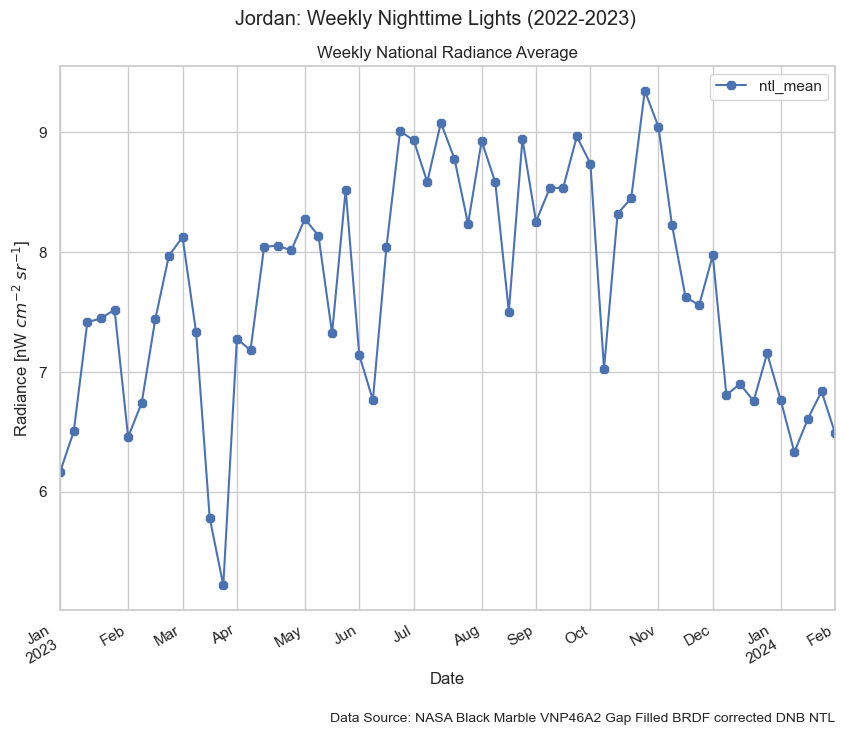

In [19]:
import matplotlib as mpl
import seaborn as sns

mpl.rcParams["font.family"] = "Arial"
sns.set_theme()
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Jordan: Weekly Nighttime Lights (2022-2023)", y=0.95)

JO_0.plot(ax=ax, marker="8")
ax.set_title("Weekly National Radiance Average")
ax.set_xlabel("Date")
ax.set_ylabel(r"Radiance [nW $cm^{-2}$ $sr^{-1}$]")
ax.ticklabel_format(style="plain", axis="y")

ax.annotate(
    "Data Source: NASA Black Marble VNP46A2 Gap Filled BRDF corrected DNB NTL",
    xy=(1.0, -0.2),
    xycoords="axes fraction",
    ha="right",
    va="center",
    fontsize=10,
)

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
fig.autofmt_xdate()

In [20]:
fig.tight_layout()
fig.savefig("JOR_0-radiance-week-mean.png", dpi=300)

## Limitations

```{seealso}
{ref}`nighttime-lights-limitations`
```